raw文件读入

In [10]:
import math

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

    
df_k = []
df_theta = []

for i in range(1,6):
    df_k.append(pd.read_csv(f'./raw_data/kz_{i}.csv'))
    df_theta.append(pd.read_csv(f'./raw_data/Theta_{i}.csv' ))
    
for i in range(5):
    print(f'kz_{i+1}.csv shape: {df_k[i].shape}')
    print(f'Theta_{i+1}.csv shape: {df_theta[i].shape}')
    
    
# 未解缠的 n_i
n_i = 1

num_rows = 804
num_cols = 2001


kz_1.csv shape: (804, 2001)
Theta_1.csv shape: (804, 2001)
kz_2.csv shape: (804, 2001)
Theta_2.csv shape: (804, 2001)
kz_3.csv shape: (804, 2001)
Theta_3.csv shape: (804, 2001)
kz_4.csv shape: (804, 2001)
Theta_4.csv shape: (804, 2001)
kz_5.csv shape: (804, 2001)
Theta_5.csv shape: (804, 2001)


重写用于打表的plot函数

In [62]:
from mpl_toolkits.mplot3d import Axes3D

def draw3D(H):
    N, M = H.shape
    x = np.linspace(1, M, M)
    y = np.linspace(1, N, N)
    x, y = np.meshgrid(x, y)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(x, y, H, cmap='viridis')

    ax.set_title('Estimated Height')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Height(m)')

    plt.show()
    

def plot(*argv, titles=None):
  """
  plots a given number of phase maps
  """
  if len(argv) == 1:
    f, ax = plt.subplots(1, 1, sharey=True, figsize=(5, 5))
    if titles is not None:
      ax.set_title(titles)
    a = ax.imshow(argv[0].squeeze(), cmap='jet')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    f.colorbar(a, cax=cax)
    plt.show()
  else:
    f, axes = plt.subplots(1, len(argv), sharey=True, figsize=(10, 10))
    for i in range(len(argv)):
        if titles is not None:
          axes[i].set_title(titles[i])
        a = axes[i].imshow(argv[i].squeeze(), cmap='jet')
        divider = make_axes_locatable(axes[i])
        cax = divider.append_axes("right", size="5%", pad=0.05)
        f.colorbar(a, cax=cax)
    plt.show()
    f.colorbar(a, cax=cax)

def plot_hist(*argv, titles):
  """
  plots the historgram of the input phase maps
  """
  for i in range(len(argv)):
      hist = np.histogram(argv[i].ravel(), bins=100)
      plt.plot(hist[1][1:], hist[0])
  plt.xlabel("phase values")
  plt.ylabel("frequency")
  plt.title("Histogram Analysis")
  plt.grid()
  if titles is not None:
    plt.legend(titles)
  plt.show()  


In [63]:
def raw_pic(index):
    
    # 创建空数组存储计算结果
    results = np.zeros((num_rows, num_cols))
    
    # 遍历每个数据点，计算结果
    for i in range(num_rows):
        for j in range(num_cols):
            k_i = df_k[index].iloc[i, j]
            theta_i = df_theta[index].iloc[i, j]
            results[i, j] = -1 / k_i * (theta_i + 2 * math.pi * n_i)
            
    return results

# 原始数据打表

> 先跑一遍原始数据，将n置为0，在不还原高程的情况下看一下相位纠缠导致的结果

另外打一个关于 theta 和 k 的表，查看相位分布情况 与 K 和 raw图的关系

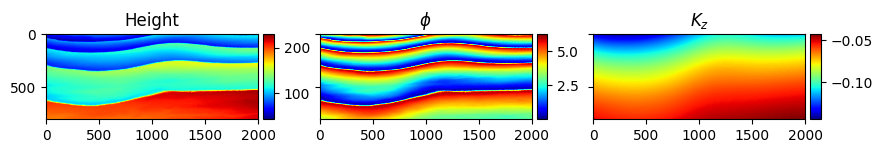

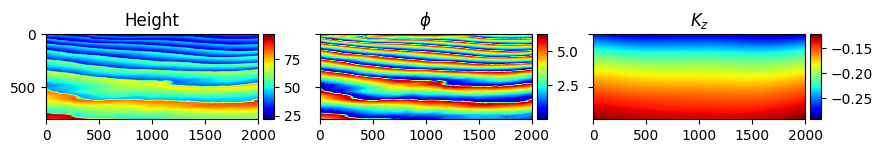

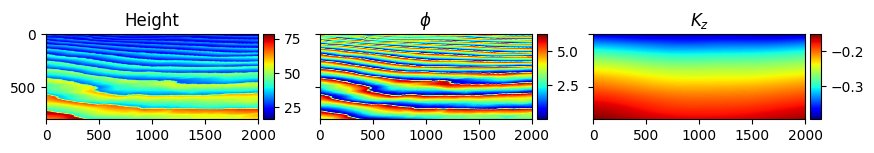

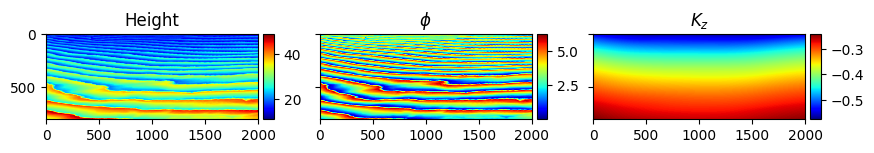

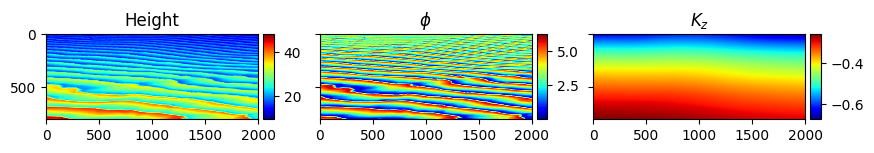

In [64]:
for i in range(5):
    plot(raw_pic(i), df_theta[i], df_k[i], titles=["Height", "$\phi$", "$K_z$"])

发现相位图与raw图在形式上是那啥的关系

基于连续性假设（相位展开）的解缠算法：

In [66]:
def unwrap_phase(theta):
    # 初始化 phi 矩阵
    phi = np.zeros_like(theta)
    phi[0, 0] = theta[0, 0]
    
    # 展开行
    for i in range(1, theta.shape[0]):
        delta = theta[i, 0] - theta[i-1, 0]
        delta_wrapped = np.mod(delta + np.pi, 2 * np.pi) - np.pi
        phi[i, 0] = phi[i-1, 0] + delta_wrapped
    
    # 展开列
    for j in range(1, theta.shape[1]):
        delta = theta[0, j] - theta[0, j-1]
        delta_wrapped = np.mod(delta + np.pi, 2 * np.pi) - np.pi
        phi[0, j] = phi[0, j-1] + delta_wrapped
    
    # 展开其余矩阵
    for i in range(1, theta.shape[0]):
        for j in range(1, theta.shape[1]):
            delta_row = theta[i, j] - theta[i-1, j]
            delta_col = theta[i, j] - theta[i, j-1]
            delta_row_wrapped = np.mod(delta_row + np.pi, 2 * np.pi) - np.pi
            delta_col_wrapped = np.mod(delta_col + np.pi, 2 * np.pi) - np.pi
            phi[i, j] = phi[i-1, j] + delta_row_wrapped
            phi[i, j] = phi[i, j-1] + delta_col_wrapped
    
    return phi


对第五组数据（考虑到raw图纠缠最复杂）输出3D高程图和2D高程图

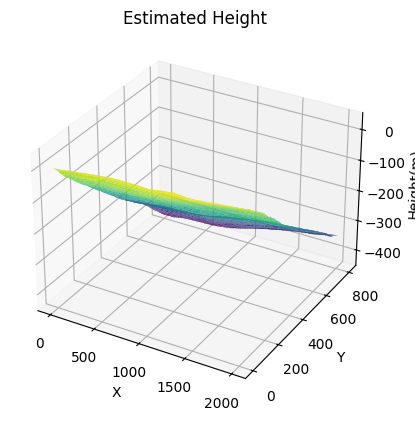

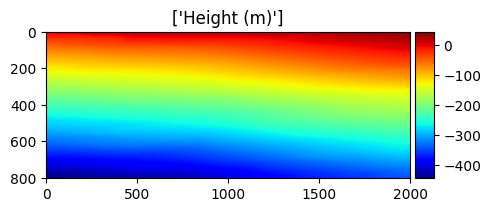

In [75]:
phi = unwrap_phase(np.array(df_theta[4]))

results = np.zeros((num_rows, num_cols))

# 遍历每个数据点，计算结果
for i in range(num_rows):
    for j in range(num_cols):
        k_i = df_k[4].iloc[i, j]
        results[i, j] = -1 / k_i * phi[i, j]

draw3D(results)

plot(results, titles=["Height (m)"])

发现解缠效果优秀，但是最后高程范围来到了负数，对此整体迭代添加周期，直至下限为150

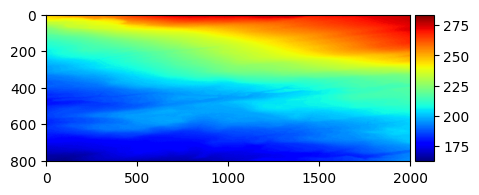

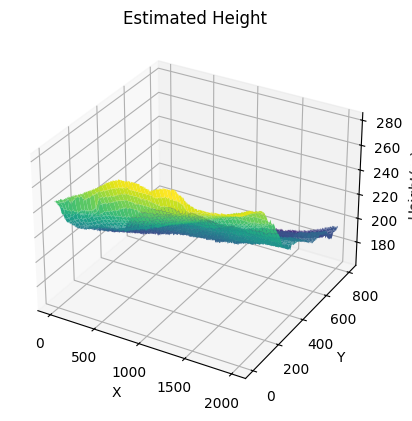

In [76]:
while np.min(results) < 150:
    results -= (2 * np.pi / df_k[4])
    
plot(results)
draw3D(results)

发现结果正好在题目给定范围内，对此做验证（1～4)组：

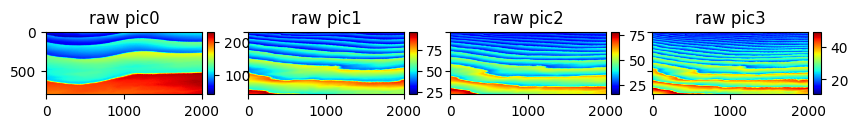

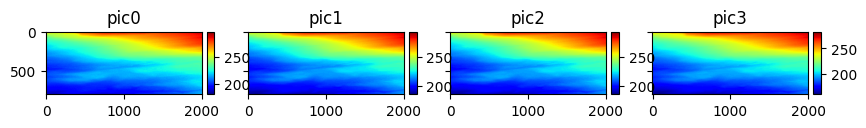

In [77]:
results = np.zeros((4, num_rows, num_cols))
for o in range(4):
    phi = unwrap_phase(np.array(df_theta[o]))
        
    for i in range(num_rows):
        for j in range(num_cols):
            k_i = df_k[o].iloc[i, j]
            results[o, i, j] = -1 / k_i * phi[i, j]
    
    while np.min(results[o]) < 150:
        results[o] -= (2 * np.pi / df_k[o])
  
plot(raw_pic(0), raw_pic(1), raw_pic(2), raw_pic(3), titles=[f"raw pic{i}" for i in range(4)])      
plot(results[0], results[1], results[2], results[3], titles=[f"pic{i}" for i in range(4)])


这里使用numpy自带的解缠方法对两个轴向上进行解缠分别查看效果（以第五组为例）

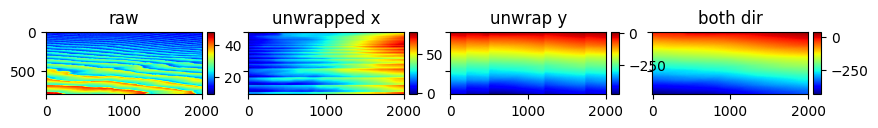

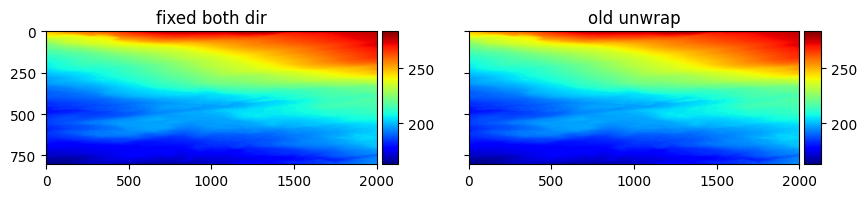

In [83]:
theta = np.array(df_theta[4]) 
k4 = np.array(df_k[4])

# 使用numpy的unwrap函数对theta进行处理
# 默认情况下，unwrap会沿着最后一个轴处理，对于二维矩阵来说，就是沿着每一行处理
# 如果你想沿着其他轴处理，可以使用axis参数
phix = np.unwrap(theta, axis=1)
phiy = np.unwrap(theta, axis=0)
phi = np.unwrap(phix, axis=0)

results = np.zeros((3 ,num_rows, num_cols))

for i in range(num_rows):
    for j in range(num_cols):
        k_i = df_k[4].iloc[i, j]
        results[0, i, j] = -1 / k_i * phix[i, j]
        results[1, i, j] = -1 / k_i * phiy[i, j]
        results[2, i ,j] = -1 / k_i * phi[i,j]


plot(raw_pic(4), results[0], results[1], results[2], titles=["raw" , "unwrapped x" ,"unwrap y", "both dir"])

while np.min(results[2]) < 150:
    results[2] -= (2 * np.pi / df_k[4])
        
results[0] = -1 / k4 * unwrap_phase(theta)
while np.min(results[0]) < 150:
    results[0] -= (2 * np.pi / df_k[4])
    
plot(results[2], results[0]  , titles=[ "fixed both dir", "old unwrap"])


可见两种方法得出的效果非常相近

自主模拟生产相位图 与 对应的纠缠图

In [99]:
from mpl_toolkits.axes_grid1 import make_axes_locatable


def simulate(size, m_1, m_2, C, A, mu_x, mu_y, sigma_x, sigma_y):
  """
  creates an arbitrary phase map by mixing gaussian blobs and adding ramps
  """
  x = np.arange(0, size[0], 1)
  y = np.arange(0, size[0], 1)
  xx, yy = np.meshgrid(x, y, sparse=True)
  I = np.zeros(size)
  ## mix randomly shaped and placed gaussian blobs
  for i in range(len(sigma_x)):
      a = (xx-mu_x[i])**2/(2*sigma_x[i]**2) + (yy-mu_y[i])**2/(2*sigma_y[i]**2)
      I += A[i]*np.exp(-a.T)
      # I += A[i]*np.exp(-a)
  ## add ramp phase with random gradients and shifts
  I = m_1*xx + m_2*yy + C + 0.1*I
  return I

def wrap(phi):
  """
  wraps the true phase signal within [-pi, pi]
  """
  return np.angle(np.exp(1j*phi))

def rescale(im, range):
  """
  mini-max rescales the input image
  """
  im_std = (im - im.min()) / (im.max() - im.min())
  im_scaled = im_std * (range[1] - range[0]) + range[0]
  return im_scaled

def create_random_image(size):
  """
  creates an randomly simulated true phase map
  """ 
  array_len = np.random.randint(2, 5)
  m = np.random.uniform(0, 0.5, [2])
  C = np.random.randint(1, 10)
  A = np.random.randint(50, 1000, array_len)
  mu_x = np.random.randint(100, 385, array_len)
  mu_y = np.random.randint(70, 355, array_len)
  sigma_x = np.random.randint(10, 45, array_len)
  sigma_y = np.random.randint(10, 45, array_len)
  I = simulate(size, m[0], m[1], C, A, mu_x, mu_y, sigma_x, sigma_y)
  return I



In [100]:
## example
size = (804, 2001)
I = create_random_image(size)
I_wrap = wrap(I)
plot(I, I_wrap, titles=["$\phi$", "$\psi$"])

ValueError: operands could not be broadcast together with shapes (804,2001) (804,804) (804,2001) 

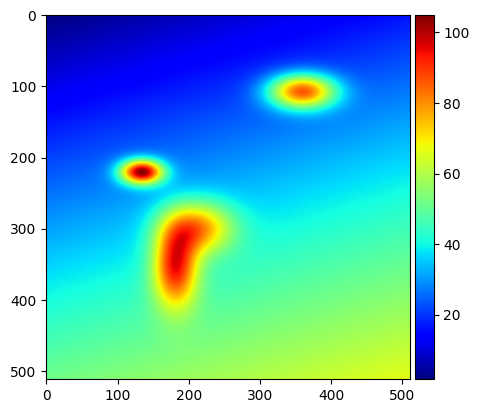

In [96]:
phi = unwrap_phase(I_wrap)

plot(phi)

以下是神经网络方法

In [ ]:
import h5py
